# Create a Simple Solar System Model

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

In [69]:
class planet():
    "A planet in our solar system"
    def __init__(self,semimajor,eccentricity):
        self.x  =np.zeros(2)
        self.v  =np.zeros(2)
        self.a_g=np.zeros(2)
        self.t  =0.0
        self.dt =0.0
        self.a  =semimajor
        self.e  =eccentricity
        self.istep=0
        self.name =""

In [70]:
solar_system = { "M_sun":1.0, "G":39.4784176043574320}

# Define some functions for setting circular velocity

In [71]:
def SolarCircularVelocity(p):
    
    G = solar_system["G"]
    M = solar_system["M_sun"]
    r = (p.x[0]**2 + p.x[1]**2 )**0.5
    
    #return the circular velocity
    return (G*M/r)**0.5

# Write a function to compute the gravitational acceleration on each planet

In [72]:
def SolarGravitationalAcceleration(p):
    
    G = solar_system["G"]
    M = solar_system["M_sun"]
    r = (p.x[0]**2 + p.x[1]**2 )**0.5
    
    #acceleration in AU/yr/yr
    a_grav = -1.0*G*M/r**2
    
    #find the angle at this position
    if(p.x[0]==0.0):
        if(p.x[1]>0.0):
            theta = 0.5*np.pi
        else:
            theta = 1.5*np.pi
    else:
        theta = np.arctan2(p.x[1],p.x[0])
    
    #set the x and y components of the velocity
    
    return a_grav*np.cos(theta), a_grav*np.sin(theta)

# Compute the timestep

In [73]:
def calc_dt(p):
    
    #integration tolerance
    ETA_TIME_STEP = 0.0004
    
    #compute timestep
    eta = ETA_TIME_STEP
    v=(p.v[0]**2 + p.v[1]**2)**0.5
    a=(p.a_g[0]**2 + p.a_g[1]**2)**0.5
    dt=eta*np.fmin(1./np.fabs(v),1./np.fabs(a)**0.5)
    
    return dt

# Define the initial conditions

In [74]:
def SetPlanet(p,i):
    
    AU_in_km = 1.495979e+8  #AU in km
    
    #circular velocity
    v_c = 0.0       #circular v in AU/yr
    v_e = 0.0       #v at perihelion in AU/yr
    
    #Mercury
    if(i==0):
        
        p.a = 57909227.0/AU_in_km
        
        p.e = 0.20563593
        
        p.name = "Mercury"
        
    elif(i==1):
        
        p.a = 108209475.0/AU_in_km
        
        p.e = 0.00677672
        
        p.name = "Venus"
        
    elif(i==2):
        
        p.a = 1.0/AU_in_km
        
        p.e = 0.01671123
        
        p.name = "Earth"
        
    #set remaining properties
    p.t = 0.0
    p.x[0] = p.a*(1.0-p.e)
    p.x[1] = 0.0
    
    #get equivalent circular velocity
    v_c=SolarCircularVelocity(p)
    v_e=v_c*(1+p.e)**0.5
    
    #set velocity
    p.v[0] = 0.0
    p.v[1] = v_e
    
    #calculate gravitational acceleration from Sun
    p.a_g = SolarGravitationalAcceleration(p)
    
    p.dt = calc_dt(p)

# Write leapfrog integrator

In [75]:
def x_first_step(x_i, v_i, a_i, dt):
    
    return x_i + 0.5*v_i*dt + 0.25*a_i*dt**2

In [76]:
def v_full_step(v_i, a_ipoh, dt):
    
    return v_i + a_ipoh*dt;

In [77]:
def x_full_step(x_ipoh, v_ipl, a_ipoh, dt):
    
    return x_ipoh + v_ipl*dt

# Write a function to save data to file

In [78]:
def SaveSolarSystem(p, n_planets, t, dt, istep, ndim):
    
    #loop over the number of planets
    for i in range(n_planets):
        
        #define a filename
        fname = "planet.%s.txt" % p[i].name
        
        if(istep==0):
            #create the file  on the first timestep
            fp = open(fname, "w")
        else:
            #append the fil on subsequent timesteps
            fp = open(fname, "a")
        
        #compute the drifted properties of the planet
        v_drift = np.zeros(ndim)
        
        for k in range(ndim):
            v_drift[k] = p[i].v[k] + 0.5*p[i].a_g[k]*p[i].dt
        
        #write data to file
        s = "%6d\t%6.5f\t%6.5f\t%6d\t%6.5f\t%6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\t% 6.5f\n" % \
        (istep, t, dt, p[i].istep, p[i].t, p[i].dt, p[i].x[0], p[i].x[1], v_drift[0], v_drift[1], p[i].a_g[0], p[i].a_g[1])
        fp.write(s)
        #close the file
        fp.close()

# Write a function to evolve the solar system

In [79]:
def EvolveSolarSystem(p,n_planets,t_max):
    
    #number of spatial dimensions
    ndim = 2
    
    #define the first timestep
    dt = 0.5/265.25
    
    #define the starting time
    t = 0.0
    
    #save the initial conditions
    istep = 0
    
    #save the initial conditions
    SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
    
    #befine a loop over the global timescale
    while(t<t_max):
        
        #check to see if th enext step exceeds the maximum time. If so, take a smaller step
        if(t+dt>t_max):
            dt = t_max - t #limit the step to align to max
            
        #evolve each planet
        for i in range(n_planets):
            
            while(p[i].t<t+dt):
                
                if(o[i].step==0):
                    for k in range(ndim):
                        p[i].x[k] = x_first_step(p[1].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                    
                    #update the acceleration
                    p[i].a_g = SolarGravitationalAccleration(p[i])
                    
                    #update the time by 1/2dt
                    p[i].t += 0.5*p[i].dt
                    
                    #update the timestep
                    p[i].dt = calc_dt(p[i])
                
                #continue with a normal step
                
                #limit to align with the global timestep
                if(p[i].t + p[i].dt > t+dt):
                    p[i].dt = t+dt-p[i].t
                
                #evolve the velocity
                for k in range(ndim):
                    p[i].v[k] = v_full_step(p[i].v[k],p[i].a_g[k],p[i].dt)
                
                #evolve the position
                for k in range(ndim):
                    p[i].x[k] = x_full_step(p[i].x[k],p[i].v[k],p[i].a_g[k],p[i].dt)
                
                #update the accleration
                p[i].a_g = SolarGravitationalAcceleration(p[i])
                
                #update by dt
                p[i].t += p[i].dt
                
                #compute the new timestep
                p[i].dt = calc_dt(p[i])
                
                #update the planet's timestep
                p[i].istep+=1
            
            t+= dt
            
            #update the global step number
            istep+=1
            
            #output the current state
            SaveSolarSystem(p,n_planets,t,dt,istep,ndim)
    
    #print the final steps and time
    print("Time t = ",t)
    print("Maximum t = ",t_max)
    print("Maximum number of steps = ",istep)

# Create a routine to read in the data

In [80]:
def read_twelve_arrays(fname):
    fp = open(fname,"r")
    fl = fp.readlines()
    n = len(fl)
    a = np.zeros(n)
    b = np.zeros(n)
    c = np.zeros(n)
    d = np.zeros(n)
    f = np.zeros(n)
    g = np.zeros(n)
    h = np.zeros(n)
    j = np.zeros(n)
    k = np.zeros(n)
    l = np.zeros(n)
    m = np.zeros(n)
    p = np.zeros(n)
    for i in range(n):
        a[i] = float(fl[i].split()[0])
        b[i] = float(fl[i].split()[0])
        c[i] = float(fl[i].split()[0])
        d[i] = float(fl[i].split()[0])
        f[i] = float(fl[i].split()[0])
        g[i] = float(fl[i].split()[0])
        h[i] = float(fl[i].split()[0])
        j[i] = float(fl[i].split()[0])
        k[i] = float(fl[i].split()[0])
        l[i] = float(fl[i].split()[0])
        m[i] = float(fl[i].split()[0])
        p[i] = float(fl[i].split()[0])
    
    return a,b,c,d,f,g,h,j,k,l,m,p

# Perform the integration of the solar system

In [81]:
#set the number of planets
n_planets = 3

#set the maximum time of the simulation
t_max = 2.0

#create the empty list of planets
p = []

#set the planets
for i in range(n_planets):
    
    #create an empty planet
    ptmp = planet(0.0,0.0)
    
    #set the planet properties
    SetPlanet(ptmp,i)
    
    #remember the planet
    p.append(ptmp)

    #evolve the solar system
    EvolveSolarSystem(p,n_planets,t_max)

IndexError: list index out of range

# Read the Data back in

In [82]:
fname = "planet.Mercury.txt"
istepMg, tMg, dtMg, istepM,tM,dtM,xM,yM,vxM,vyM,axM,ayM = read_twelve_arrays(fname)

In [83]:
fname = "planet.Earth.txt"
istepEg,tEg,dtEg,istepE,tE,dtE,xE,yE,vxE,vyE,axE,ayE = read_twelve_arrays(fname)

FileNotFoundError: [Errno 2] No such file or directory: 'planet.Earth.txt'

In [84]:
fname = "planet.Venus.txt"
istepVg,tVg,dtVg,istepV,tV,dtV,xV,yV,vxV,vyV,axV,ayV = read_twelve_arrays(fname)

FileNotFoundError: [Errno 2] No such file or directory: 'planet.Venus.txt'

# Plot the Data

NameError: name 'xV' is not defined

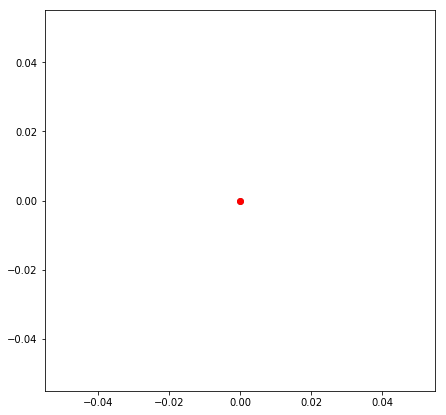

In [85]:
fig = plt.figure(figsize=(7,7))

xSun = [0.0]
ySun = [0.0]
plt.plot(xSun,ySun,'o',color="0.5",label="Sun")

plt.plot(xM,yM,color="red")
plt.plot(xM[-1],yM[-1],'o',color="red",label="Mercury")

plt.plot(xV,yV,color="green")
plt.plot(xV[-1],yV[-1],'o',color="green",label="Venus")

plt.plot(xE,yE,color="blue")
plt.plot(xE[-1],yE[-1],'o',color="blue",label="Earth")


plt.xlim([-1.25,1.25])
plt.ylim([-1.25,1.25])
plt.xlabel('x[AU]')
plt.ylabel('y[AU]')
plt.axes().set_aspect('equal')
plt.legend(frameon=False,loc=2)